# Paper CHF - 4 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_4beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,13.102095,13.097001,13.072790,3.706391,0.542614,1.240982,-0.895934,-2.712703,-2.663057,...,-0.069056,0.062074,-0.071315,0.072003,-0.085813,0.018093,-0.024765,-0.023205,0.019933,NSR
1,e0106,17.487040,17.476616,17.514101,4.949534,0.713287,1.208352,-0.835234,-1.803925,-2.177733,...,-0.033026,0.017482,-0.014863,0.016572,-0.072260,0.024719,-0.037654,-0.001608,-0.009617,NSR
2,e0106,17.765692,18.767421,18.563219,5.234889,0.756572,1.239086,-0.727071,-1.738814,-2.078783,...,-0.036041,0.011065,-0.006174,0.017821,-0.030732,-0.027515,-0.018567,0.002476,-0.011823,NSR
3,e0106,17.472889,18.368493,18.044299,5.083577,0.745658,1.200223,-0.800412,-1.813089,-2.117043,...,-0.013610,-0.003827,-0.018916,0.046067,-0.068930,0.005377,-0.029879,0.006491,-0.021803,NSR
4,e0106,16.631755,17.107590,16.986173,4.785861,0.705577,1.207803,-0.814830,-1.677964,-1.684348,...,-0.050212,0.021235,-0.011183,0.030903,-0.061186,-0.018751,0.003333,-0.020661,0.007397,NSR


In [5]:
data['label'].value_counts()

NSR    104876
ST-     21993
ST+      9879
Name: label, dtype: int64

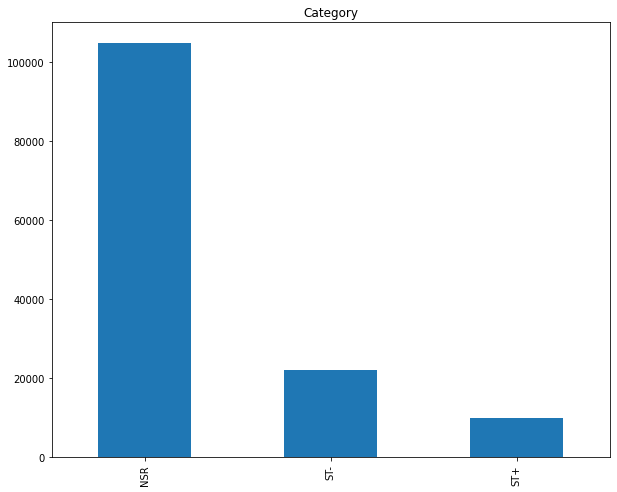

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.312273,0.162467,0.110289,0.114818,0.091114,-0.029557,0.006399,-0.000875,0.001703,...,-0.042191,-0.050062,-0.008514,0.005894,0.015042,-0.023458,-0.014237,-0.036773,-0.059384,-0.038783
dw_2,0.312273,1.000000,0.840060,0.440370,0.158646,0.415202,-0.437598,-0.206089,-0.003727,0.005025,...,-0.143619,0.102186,0.218697,0.162054,0.045198,0.025353,0.101591,-0.013728,-0.121356,-0.078300
dw_3,0.162467,0.840060,1.000000,0.613108,0.233954,0.305744,-0.499972,-0.269989,-0.004282,0.002581,...,-0.201584,0.090697,0.252037,0.115305,-0.043451,0.034627,0.045318,-0.033912,-0.133216,-0.044818
dw_4,0.110289,0.440370,0.613108,1.000000,0.900298,0.029004,-0.221348,-0.125818,-0.001509,0.000622,...,-0.139370,0.027890,0.115591,0.036784,-0.040897,0.031590,0.027101,-0.027459,-0.083792,-0.027346
dw_5,0.114818,0.158646,0.233954,0.900298,1.000000,-0.093747,-0.013018,-0.014289,0.000039,-0.000191,...,-0.065101,-0.007436,0.022364,0.006044,-0.015060,0.013505,0.011685,-0.024332,-0.037581,-0.015057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.023458,0.025353,0.034627,0.031590,0.013505,-0.078775,0.021517,0.061659,0.000381,0.003797,...,-0.114312,-0.205332,-0.130827,-0.012334,0.047726,1.000000,-0.024143,-0.054066,-0.277308,-0.170496
cfr_13,-0.014237,0.101591,0.045318,0.027101,0.011685,0.077259,0.004550,0.003053,-0.000895,0.001937,...,0.110173,0.020152,-0.217039,-0.265132,-0.093551,-0.024143,1.000000,0.126068,0.040084,-0.170708
cfr_14,-0.036773,-0.013728,-0.033912,-0.027459,-0.024332,0.014857,0.010542,0.014576,-0.000553,0.000869,...,0.077729,0.198416,0.039598,-0.185391,-0.289586,-0.054066,0.126068,1.000000,0.090389,-0.160650
cfr_15,-0.059384,-0.121356,-0.133216,-0.083792,-0.037581,0.017184,0.080945,0.046306,0.003503,-0.004316,...,0.231845,0.160889,-0.064172,-0.148376,-0.122505,-0.277308,0.040084,0.090389,1.000000,0.127273


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
patient_ids = data["id"].values

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_138', 'fft_191', 'fft_225', 'fft_133', 'fft_209', 'fft_136', 'fft_152', 'fft_192', 'fft_213', 'fft_141', 'fft_156', 'fft_256', 'fft_233', 'fft_217', 'mfw_15', 'fft_132', 'fft_186', 'fft_238', 'fft_253', 'cfr_16', 'fft_207', 'fft_172', 'fft_179', 'fft_251', 'fft_145', 'mfw_11', 'fft_198', 'mfw_6', 'fft_219', 'fft_189', 'fft_239', 'fft_196', 'fft_168', 'fft_193', 'mfw_12', 'fft_150', 'fft_232', 'fft_175', 'fft_194', 'mfw_9', 'fft_204', 'fft_158', 'fft_210', 'mfw_7', 'fft_149', 'fft_173', 'fft_180', 'fft_218', 'fft_250', 'mfw_8', 'fft_177', 'fft_174', 'fft_248', 'fft_226', 'fft_182', 'fft_135', 'fft_220', 'fft_208', 'fft_187', 'fft_231', 'fft_137', 'fft_197', 'fft_255', 'fft_230', 'fft_184', 'fft_190', 'fft_154', 'fft_171', 'fft_227', 'fft_164', 'fft_195', 'fft_199', 'fft_203', 'fft_188', 'mfw_13', 'fft_163', 'fft_131', 'fft_249', 'fft_228', 'fft_162', 'fft_247', 'mfw_10', 'fft_151', 'fft_134', 'fft_237', 'fft_165', 'fft_167', 'fft_244', 'fft_214', 'fft_139', 'fft_140', 'fft_246', '

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 74


### Visualization best features

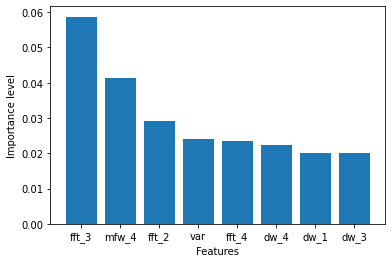

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,13.102095,13.097001,13.072790,3.706391,0.542614,1.240982,-0.895934,-2.712703,-2.663057,0.294201,...,-0.013426,0.064171,-0.069056,0.062074,-0.071315,0.072003,-0.085813,0.018093,-0.024765,-0.023205
1,17.487040,17.476616,17.514101,4.949534,0.713287,1.208352,-0.835234,-1.803925,-2.177733,-1.533708,...,0.016671,0.036579,-0.033026,0.017482,-0.014863,0.016572,-0.072260,0.024719,-0.037654,-0.001608
2,17.765692,18.767421,18.563219,5.234889,0.756572,1.239086,-0.727071,-1.738814,-2.078783,-0.720965,...,0.020868,0.035213,-0.036041,0.011065,-0.006174,0.017821,-0.030732,-0.027515,-0.018567,0.002476
3,17.472889,18.368493,18.044299,5.083577,0.745658,1.200223,-0.800412,-1.813089,-2.117043,0.838703,...,0.026449,0.028665,-0.013610,-0.003827,-0.018916,0.046067,-0.068930,0.005377,-0.029879,0.006491
4,16.631755,17.107590,16.986173,4.785861,0.705577,1.207803,-0.814830,-1.677964,-1.684348,-0.600837,...,-0.015116,0.060441,-0.050212,0.021235,-0.011183,0.030903,-0.061186,-0.018751,0.003333,-0.020661


## Random Forest - L1SO

In [17]:
cvds = X_fsel.copy()
cvds["patient_id"] = patient_ids
cvds["label"] = y

patients = np.unique(cvds["patient_id"].values)
patients

array(['e0106', 'e0110', 'e0115', 'e0129', 'e0133', 'e0151', 'e0202',
       'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210',
       'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305',
       'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409',
       'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0515',
       'e0601', 'e0602', 'e0603', 'e0605', 'e0606', 'e0607', 'e0609',
       'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704',
       'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304'],
      dtype=object)

In [18]:
classes = np.unique(label_encoder.inverse_transform(y))

In [19]:
result_df = pd.DataFrame()
tot = len(patients)
for i, patient in enumerate(patients):
    start_time = time.time()

    # Train and Test split
    df1 = cvds.loc[cvds["patient_id"] != patient]
    df2 = cvds.loc[cvds["patient_id"] == patient]

    y_train = df1["label"].values
    x_train = df1.loc[:, ~df1.columns.isin(['patient_id', 'label'])]
    y_test = df2["label"].values
    x_test = df2.loc[:, ~df2.columns.isin(['patient_id', 'label'])]

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(patients), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
1 of 56 - 45.75189208984375 s
Tot: Accuracy 0.8215077605321508 Precision 0.853420309731844 Recall 0.8215077605321508 Specificity 0.18772300869861847 F1 0.7426555486452869
NSR: Accuracy 0.8215077605321508 Precision 0.8212104386451972 Recall 1.0 Specificity 0.009230769230769232 F1 0.901829268292683
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.009230769230769232 Specificity 1.0 F1 0.01829268292682927
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
2 of 56 - 45.2842116355896 s
Tot: Accuracy 0.8014664410603497 Precision 0.8408820150855933 Recall 0.8014664410603497 Specificity 0.1985335589396503 F1 0.7131395195659092
NSR: Accuracy 0.8014664410603497 Precision 0.8014664410603497 Recall 1.0 Specificity 0.0 F1 0.8897933625547902
ST+: Accuracy 0.8014664410603497 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.8014664410603497 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
3 of 56 - 46.37788939476013 s
Tot: Accuracy 0.9197465681098205 Precision 0.8831590458785167 Recall 0.9197465681098205 Specificity 0.09596179991191271 F1 0.8842866119329079
NSR: Accuracy 0.9197465681098205 Precision 0.9212570621468926 Recall 0.9980872226472839 Specificity 0.01762114537444934 F1 0.95813441057657
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.4444444444444444 Recall 0.01762114537444934 Specificity 0.9980872226472839 F1 0.03389830508474576
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
4 of 56 - 48.377763748168945 s
Tot: Accuracy 0.8665269042627534 Precision 0.8843419715484376 Recall 0.8665269042627534 Specificity 0.1334730957372467 F1 0.8045626067284268
NSR: Accuracy 0.8665269042627534 Precision 0.8665269042627534 Recall 1.0 Specificity 0.0 F1 0.9284912017970797
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
5 of 56 - 45.135780572891235 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
6 of 56 - 46.55659246444702 s
Tot: Accuracy 0.9963560645497137 Precision 1.0 Recall 0.9963560645497137 Specificity 0.0 F1 0.9981747066492831
NSR: Accuracy 0.9963560645497137 Precision 1.0 Recall 0.9963560645497137 Specificity 0.0 F1 0.998174706649283
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9963560645497137 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
7 of 56 - 48.700984477996826 s
Tot: Accuracy 0.7249900358708649 Precision 0.8015357701383531 Recall 0.7249900358708649 Specificity 0.3166766307958018 F1 0.6207156392563155
NSR: Accuracy 0.7249900358708649 Precision 0.7216619604679306 Recall 1.0 Specificity 0.041666666666666664 F1 0.8383317713214621
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.041666666666666664 Specificity 1.0 F1 0.07999999999999999
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
8 of 56 - 48.358232259750366 s
Tot: Accuracy 0.7755181853734846 Precision 0.7834877434363889 Recall 0.7755181853734846 Specificity 0.3864235594186793 F1 0.7168383439920932
NSR: Accuracy 0.7755181853734846 Precision 0.773311230832988 Recall 0.9857369255150554 Specificity 0.17620481927710843 F1 0.8666976312122621
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8125 Recall 0.17620481927710843 Specificity 0.9857369255150554 F1 0.2896039603960396
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
9 of 56 - 45.937490463256836 s
Tot: Accuracy 0.8074534161490683 Precision 0.9844663297829066 Recall 0.8074534161490683 Specificity 0.7840898922764492 F1 0.8820880269638034
NSR: Accuracy 0.8074534161490683 Precision 0.9965502371711945 Recall 0.8077595246417336 Specificity 0.7837837837837838 F1 0.8922779922779923
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.05008635578583765 Recall 0.7837837837837838 Specificity 0.8077595246417336 F1 0.09415584415584415
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
10 of 56 - 45.69824552536011 s
Tot: Accuracy 0.6508777740973832 Precision 0.7727641027165811 Recall 0.6508777740973832 Specificity 0.34912222590261677 F1 0.5132322737164359
NSR: Accuracy 0.6508777740973832 Precision 0.6508777740973832 Recall 1.0 Specificity 0.0 F1 0.7885232744783307
ST+: Accuracy 0.6508777740973832 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6508777740973832 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
11 of 56 - 46.113261222839355 s
Tot: Accuracy 0.8071195059934617 Precision 0.809954180898605 Recall 0.8071195059934617 Specificity 0.5038874556146069 F1 0.789528797635643
NSR: Accuracy 0.8114783872139484 Precision 0.832016632016632 Recall 0.9456521739130435 Specificity 0.36577708006279436 F1 0.8852023888520238
ST+: Accuracy 0.982564475118053 Precision 0.0 Recall 1.0 Specificity 0.982564475118053 F1 0.0
ST-: Accuracy 0.982564475118053 precision 0.7366666666666667 Recall 0.3469387755102041 Specificity 0.9626654064272212 F1 0.471718249733191
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
12 of 56 - 46.83391571044922 s
Tot: Accuracy 0.7560706401766004 Precision 0.8155721727604539 Recall 0.7560706401766004 Specificity 0.24392935982339956 F1 0.6510476285618747
NSR: Accuracy 0.7560706401766004 Precision 0.7560706401766004 Recall 1.0 Specificity 0.0 F1 0.8610936517913262
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
13 of 56 - 43.470850467681885 s
Tot: Accuracy 0.9053013140009062 Precision 0.9142691551308612 Recall 0.9053013140009062 Specificity 0.0946986859990938 F1 0.8603053628412891
NSR: Accuracy 0.9053013140009062 Precision 0.9053013140009062 Recall 1.0 Specificity 0.0 F1 0.9502972651605232
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
14 of 56 - 44.851621866226196 s
Tot: Accuracy 0.8104545454545454 Precision 0.8463820247933883 Recall 0.8104545454545454 Specificity 0.18954545454545454 F1 0.7256040444616894
NSR: Accuracy 0.8104545454545454 Precision 0.8104545454545454 Recall 1.0 Specificity 0.0 F1 0.8953050464474014
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
15 of 56 - 43.06169676780701 s
Tot: Accuracy 0.7647214153683655 Precision 0.6708077828925803 Recall 0.7647214153683655 Specificity 0.17740398651236086 F1 0.7132874710904554
NSR: Accuracy 0.7647214153683655 Precision 0.8105529048554588 Recall 0.9304123711340206 Specificity 0.01171303074670571 F1 0.8663566821658918
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.03571428571428571 Recall 0.01171303074670571 Specificity 0.9304123711340206 F1 0.017640573318632856
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
16 of 56 - 43.66810345649719 s
Tot: Accuracy 0.9477911646586346 Precision 0.9505179226768286 Recall 0.9477911646586346 Specificity 0.059153279785809906 F1 0.9227467763681637
NSR: Accuracy 0.9477911646586346 Precision 0.9477720964207451 Recall 1.0 Specificity 0.006944444444444444 F1 0.9731858241140071
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.006944444444444444 Specificity 1.0 F1 0.013793103448275862
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
17 of 56 - 44.58113241195679 s
Tot: Accuracy 0.7361505681818182 Precision 0.7411535866316096 Recall 0.7361505681818182 Specificity 0.3672230659943485 F1 0.6591914824458439
NSR: Accuracy 0.7361505681818182 Precision 0.735217552993678 Recall 0.9845617529880478 Specificity 0.1188118811881188 F1 0.8418139237811371
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.7559055118110236 Recall 0.1188118811881188 Specificity 0.9845617529880478 F1 0.20534759358288768
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
18 of 56 - 43.35562491416931 s
Tot: Accuracy 0.9695110258868648 Precision 0.9704406034293362 Recall 0.9695110258868648 Specificity 0.030488974113135187 F1 0.9545025307923255
NSR: Accuracy 0.9695110258868648 Precision 0.9695110258868648 Recall 1.0 Specificity 0.0 F1 0.9845195209814038
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
19 of 56 - 44.612377643585205 s
Tot: Accuracy 0.8583556747095621 Precision 0.7382012354501288 Recall 0.8583556747095621 Specificity 0.14060428368877384 F1 0.7937571351125212
NSR: Accuracy 0.8583556747095621 Precision 0.8591234347048301 Recall 0.998959958398336 Specificity 0.0 F1 0.9237797547487376
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.998959958398336 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
20 of 56 - 42.929868936538696 s
Tot: Accuracy 0.9854484732824428 Precision 0.9786050811068703 Recall 0.9854484732824428 Specificity 0.010693315962794773 F1 0.9820148549086364
NSR: Accuracy 0.9854484732824428 Precision 0.9892241379310345 Recall 0.9961417892452376 Specificity 0.0 F1 0.9926709119307942
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9961417892452376 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
21 of 56 - 43.79700255393982 s
Tot: Accuracy 0.8176470588235294 Precision 0.8265597147950089 Recall 0.8176470588235294 Specificity 0.21053283259127187 F1 0.7415345268542199
NSR: Accuracy 0.8176470588235294 Precision 0.8173361522198731 Recall 0.9989664082687338 Specificity 0.029213483146067417 F1 0.8990697674418605
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8666666666666667 Recall 0.029213483146067417 Specificity 0.9989664082687338 F1 0.05652173913043478
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
22 of 56 - 44.42000889778137 s
Tot: Accuracy 0.6735102653980971 Precision 0.780105812198518 Recall 0.6735102653980971 Specificity 0.32648973460190284 F1 0.542113289623244
NSR: Accuracy 0.6735102653980971 Precision 0.6735102653980971 Recall 1.0 Specificity 0.0 F1 0.8049072411729503
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
23 of 56 - 44.15928292274475 s
Tot: Accuracy 0.35460385438972164 Precision 0.6000378393032929 Recall 0.35460385438972164 Specificity 0.6622794689365802 F1 0.2573245527767366
NSR: Accuracy 0.3683083511777302 Precision 0.3341232227488152 Recall 0.9096774193548387 Specificity 0.09935897435897435 F1 0.488734835355286
ST+: Accuracy 0.3653104925053533 Precision 0.7321428571428571 Recall 0.07884615384615384 Specificity 0.9419354838709677 F1 0.1423611111111111
ST-: Accuracy 0.3653104925053533 precision 0.0 Recall 1.0 Specificity 0.9755888650963598 F1 0.0
#---------------------#
#---------------------#
24 of 56 - 44.89556360244751 s
Tot: Accuracy 0.843607305936073 Precision 0.7773776908023483 Recall 0.843607305936073 Specificity 0.1551364126568918 F1 0.7730890481643271
NSR: Accuracy 0.843607305936073 Precision 0.8445714285714285 Recall 0.9986486486486487 Specificity 0.0 F1 0.915170278637771
ST+: Accuracy 0.9075342465753424 Precision 0.0 Recall 0.0 Specificity 0.998743718

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
25 of 56 - 45.133832931518555 s
Tot: Accuracy 0.6953264359614698 Precision 0.7634311223322997 Recall 0.6953264359614698 Specificity 0.3628813072848591 F1 0.5896503355716439
NSR: Accuracy 0.6953264359614698 Precision 0.6904848705796574 Recall 0.9973670352817272 Specificity 0.06084070796460177 F1 0.8160275743214132
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9166666666666666 Recall 0.06084070796460177 Specificity 0.9973670352817272 F1 0.1141078838174274
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
26 of 56 - 45.67578721046448 s
Tot: Accuracy 0.7285966460723742 Precision 0.5810849033577129 Recall 0.7285966460723742 Specificity 0.26739817409200106 F1 0.618736535047642
NSR: Accuracy 0.7285966460723742 Precision 0.7320319432120674 Recall 0.9933774834437086 Specificity 0.001652892561983471 F1 0.842911877394636
ST+: Accuracy 0.9973521624007061 Precision 0.0 Recall 1.0 Specificity 0.9973521624007061 F1 0.0
ST-: Accuracy 0.9973521624007061 precision 0.16666666666666666 Recall 0.001652892561983471 Specificity 0.9969897652016857 F1 0.003273322422258592
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
27 of 56 - 45.39455485343933 s
Tot: Accuracy 0.8353148392778512 Precision 0.8413937530279284 Recall 0.8353148392778512 Specificity 0.1680172905095271 F1 0.8344447766883596
NSR: Accuracy 0.8353148392778512 Precision 0.9042348411934552 Recall 0.9148003894839338 Specificity 0.08294930875576037 F1 0.9094869312681509
ST+: Accuracy 0.9471598414795245 Precision 0.0 Recall 1.0 Specificity 0.9471598414795245 F1 0.0
ST-: Accuracy 0.9471598414795245 precision 0.2465753424657534 Recall 0.08294930875576037 Specificity 0.9732229795520935 F1 0.12413793103448276
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
28 of 56 - 44.4541871547699 s
Tot: Accuracy 0.347906976744186 Precision 0.9546811680776703 Recall 0.347906976744186 Specificity 0.9666460487351303 F1 0.4619031679613459
NSR: Accuracy 0.347906976744186 Precision 0.06908768821966342 Recall 0.9936305732484076 Specificity 0.31486310299869624 F1 0.12919254658385096
ST+: Accuracy 0.9996899224806202 Precision 0.0 Recall 1.0 Specificity 0.9996899224806202 F1 0.0
ST-: Accuracy 0.9996899224806202 precision 1.0 Recall 0.31486310299869624 Specificity 1.0 F1 0.4789291026276649
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
29 of 56 - 49.0271372795105 s
Tot: Accuracy 0.14383561643835616 Precision 0.8768530681178457 Recall 0.14383561643835616 Specificity 0.8561643835616438 F1 0.03617422688868838
NSR: Accuracy 0.14383561643835616 Precision 0.14383561643835616 Recall 1.0 Specificity 0.0 F1 0.25149700598802394
ST+: Accuracy 0.14383561643835616 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.14383561643835616 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
30 of 56 - 45.1758189201355 s
Tot: Accuracy 0.922585794094174 Precision 0.9304715083798882 Recall 0.922585794094174 Specificity 0.08031095740592947 F1 0.8875363441628403
NSR: Accuracy 0.9229848363926576 Precision 0.9248 Recall 0.9978420371169616 Specificity 0.005291005291005291 F1 0.9599335686111687
ST+: Accuracy 0.9976057462090981 Precision 0.0 Recall 1.0 Specificity 0.9976057462090981 F1 0.0
ST-: Accuracy 0.9976057462090981 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
31 of 56 - 44.94299864768982 s
Tot: Accuracy 0.9142717973697029 Precision 0.9034964414562158 Recall 0.9142717973697029 Specificity 0.47388358980231765 F1 0.9061569057232916
NSR: Accuracy 0.9142717973697029 Precision 0.9346576058546785 Recall 0.9722675367047309 Specificity 0.4158878504672897 F1 0.9530916844349681
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6357142857142857 Recall 0.4158878504672897 Specificity 0.9722675367047309 F1 0.5028248587570623
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
32 of 56 - 44.32431244850159 s
Tot: Accuracy 0.5151001017984391 Precision 0.7395172851506563 Recall 0.5151001017984391 Specificity 0.5507044839737668 F1 0.38586651535769445
NSR: Accuracy 0.5151001017984391 Precision 0.4978858350951374 Recall 0.9971771347918137 Specificity 0.06862745098039216 F1 0.6641598119858989
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.963302752293578 Recall 0.06862745098039216 Specificity 0.9971771347918137 F1 0.1281269066503966
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
33 of 56 - 45.33694005012512 s
Tot: Accuracy 0.8475161987041037 Precision 0.8707775564644542 Recall 0.8475161987041037 Specificity 0.15530866005295849 F1 0.7779993599325989
NSR: Accuracy 0.8475161987041037 Precision 0.8474503025064822 Recall 1.0 Specificity 0.002824858757062147 F1 0.9174269005847953
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.002824858757062147 Specificity 1.0 F1 0.005633802816901409
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
34 of 56 - 47.47547698020935 s
Tot: Accuracy 0.5599455040871935 Precision 0.9291107147839665 Recall 0.5599455040871935 Specificity 0.8617741263800891 F1 0.663913342807348
NSR: Accuracy 0.5599455040871935 Precision 0.9853137516688919 Recall 0.5375091041514931 Specificity 0.8842105263157894 F1 0.6955702167766259
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.1168289290681502 Recall 0.8842105263157894 Specificity 0.5375091041514931 F1 0.2063882063882064
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
35 of 56 - 45.13968825340271 s
Tot: Accuracy 0.9448301059554256 Precision 0.9506477970507342 Recall 0.9448301059554256 Specificity 0.05188162221410303 F1 0.9212226657728084
NSR: Accuracy 0.9448301059554256 Precision 0.9479472140762464 Recall 0.9965317919075144 Specificity 0.0 F1 0.9716325380424572
ST+: Accuracy 0.9967117281695287 Precision 0.0 Recall 1.0 Specificity 0.9967117281695287 F1 0.0
ST-: Accuracy 0.9967117281695287 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
36 of 56 - 45.810543060302734 s
Tot: Accuracy 0.9776785714285714 Precision 1.0 Recall 0.9776785714285714 Specificity 0.0 F1 0.9887133182844244
NSR: Accuracy 0.9776785714285714 Precision 1.0 Recall 0.9776785714285714 Specificity 0.0 F1 0.9887133182844243
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9776785714285714 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
37 of 56 - 46.30465340614319 s
Tot: Accuracy 0.8673070081821416 Precision 0.8690929054709661 Recall 0.8673070081821416 Specificity 0.4377613838945937 F1 0.8681883770680179
NSR: Accuracy 0.8673070081821416 Precision 0.9274322169059012 Recall 0.9241160111243544 Specificity 0.38095238095238093 F1 0.925771144278607
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.3696369636963696 Recall 0.38095238095238093 Specificity 0.9241160111243544 F1 0.37520938023450584
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
38 of 56 - 44.37411427497864 s
Tot: Accuracy 0.06146926536731634 Precision 0.7020700159227522 Recall 0.06146926536731634 Specificity 0.7804412360668924 F1 0.04893710297129355
NSR: Accuracy 0.06296851574212893 Precision 0.03929679420889348 Recall 0.8172043010752689 Specificity 0.02620545073375262 F1 0.07498766650222004
ST+: Accuracy 0.06146926536731634 Precision 0.734375 Recall 0.024633123689727462 Specificity 0.8172043010752689 F1 0.04766734279918864
ST-: Accuracy 0.06146926536731634 precision 0.0 Recall 1.0 Specificity 0.9985007496251874 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
39 of 56 - 43.857550382614136 s
Tot: Accuracy 0.8106448311156602 Precision 0.7988581345929545 Recall 0.8106448311156602 Specificity 0.504885793672447 F1 0.7878197061253956
NSR: Accuracy 0.8109860116001365 Precision 0.8263239875389408 Recall 0.9515695067264573 Specificity 0.3637660485021398 F1 0.8845352230095872
ST+: Accuracy 0.9979529170931423 Precision 0.0 Recall 1.0 Specificity 0.9979529170931423 F1 0.0
ST-: Accuracy 0.9979529170931423 precision 0.711484593837535 Recall 0.362339514978602 Specificity 0.9538116591928251 F1 0.4801512287334594
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
40 of 56 - 43.76673150062561 s
Tot: Accuracy 0.9192622950819672 Precision 0.9213007886806164 Recall 0.9192622950819672 Specificity 0.6791786359676595 F1 0.9120547171859733
NSR: Accuracy 0.9192622950819672 Precision 0.9156177156177157 Recall 0.9919191919191919 Specificity 0.6065217391304348 F1 0.9522424242424242
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9457627118644067 Recall 0.6065217391304348 Specificity 0.9919191919191919 F1 0.7390728476821192
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
41 of 56 - 45.10648846626282 s
Tot: Accuracy 0.3751442862639477 Precision 0.7704561986548121 Recall 0.3751442862639477 Specificity 0.6441793852336368 F1 0.21911555088588178
NSR: Accuracy 0.3751442862639477 Precision 0.3673548889754577 Recall 1.0 Specificity 0.01932367149758454 F1 0.5373219373219373
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.01932367149758454 Specificity 1.0 F1 0.03791469194312796
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
42 of 56 - 44.88677453994751 s
Tot: Accuracy 0.9216433714527742 Precision 0.9498279938659795 Recall 0.9216433714527742 Specificity 0.7554361328270136 F1 0.9321858372793563
NSR: Accuracy 0.9216433714527742 Precision 0.9834044570886676 Recall 0.9325539568345323 Specificity 0.7445255474452555 F1 0.9573044080313869
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.40476190476190477 Recall 0.7445255474452555 Specificity 0.9325539568345323 F1 0.5244215938303342
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
43 of 56 - 45.14554762840271 s
Tot: Accuracy 0.8572136836886465 Precision 0.8776016158144123 Recall 0.8572136836886465 Specificity 0.1427863163113535 F1 0.7913093748519326
NSR: Accuracy 0.8572136836886465 Precision 0.8572136836886465 Recall 1.0 Specificity 0.0 F1 0.9231179925253604
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
44 of 56 - 45.442405462265015 s
Tot: Accuracy 0.9993284083277367 Precision 1.0 Recall 0.9993284083277367 Specificity 0.0 F1 0.9996640913671482
NSR: Accuracy 0.9993284083277367 Precision 1.0 Recall 0.9993284083277367 Specificity 0.0 F1 0.9996640913671482
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9993284083277367 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
45 of 56 - 47.550668716430664 s
Tot: Accuracy 0.6107042253521127 Precision 0.5701368460621766 Recall 0.6107042253521127 Specificity 0.3934685691423996 F1 0.46782157946952807
NSR: Accuracy 0.6140845070422535 Precision 0.6144236229415105 Recall 0.9944852941176471 Specificity 0.011644832605531296 F1 0.7595647595647597
ST+: Accuracy 0.6129577464788732 Precision 0.5 Recall 0.002911208151382824 Specificity 0.9981617647058824 F1 0.0057887120115774245
ST-: Accuracy 0.6129577464788732 precision 0.0 Recall 1.0 Specificity 0.9943661971830986 F1 0.0
#---------------------#
#---------------------#
46 of 56 - 49.67943572998047 s
Tot: Accuracy 0.7553244180287271 Precision 0.8151905584417082 Recall 0.7553244180287271 Specificity 0.2446755819712729 F1 0.6500393552448132
NSR: Accuracy 0.7553244180287271 Precision 0.7553244180287271 Recall 1.0 Specificity 0.0 F1 0.8606094808126411
ST+: Accuracy 0.9806835066864784 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.9806

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
47 of 56 - 47.282787561416626 s
Tot: Accuracy 0.5409663865546218 Precision 0.6330552889870547 Recall 0.5409663865546218 Specificity 0.6419672186117608 F1 0.5307100889392472
NSR: Accuracy 0.5577731092436975 Precision 0.48207975769813227 Recall 0.8011744966442953 Specificity 0.38341346153846156 F1 0.6019539867633156
ST+: Accuracy 0.9723389355742297 Precision 0.0 Recall 1.0 Specificity 0.9723389355742297 F1 0.0
ST-: Accuracy 0.9723389355742297 precision 0.7412060301507538 Recall 0.3545673076923077 Specificity 0.8271812080536913 F1 0.4796747967479675
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
48 of 56 - 48.22738265991211 s
Tot: Accuracy 0.9786301369863014 Precision 0.9781835681219795 Recall 0.9786301369863014 Specificity 0.177486835066262 F1 0.9784057635832959
NSR: Accuracy 0.9786301369863014 Precision 0.9889012208657048 Recall 0.9894503053858967 Specificity 0.16666666666666666 F1 0.9891756869275604
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.17391304347826086 Recall 0.16666666666666666 Specificity 0.9894503053858967 F1 0.1702127659574468
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
49 of 56 - 45.0626380443573 s
Tot: Accuracy 0.9869865799105327 Precision 1.0 Recall 0.9869865799105327 Specificity 0.0 F1 0.9934506753990994
NSR: Accuracy 0.9869865799105327 Precision 1.0 Recall 0.9869865799105327 Specificity 0.0 F1 0.9934506753990994
ST+: Accuracy 0.9983733224888166 Precision 0.0 Recall 1.0 Specificity 0.9983733224888166 F1 0.0
ST-: Accuracy 0.9983733224888166 precision 0.0 Recall 1.0 Specificity 0.9886132574217161 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
50 of 56 - 43.243327379226685 s
Tot: Accuracy 0.9975206611570248 Precision 1.0 Recall 0.9975206611570248 Specificity 0.0 F1 0.9987587918907735
NSR: Accuracy 0.9975206611570248 Precision 1.0 Recall 0.9975206611570248 Specificity 0.0 F1 0.9987587918907737
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9975206611570248 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
51 of 56 - 43.325966596603394 s
Tot: Accuracy 0.11663143058491895 Precision 0.8935818360597121 Recall 0.11663143058491895 Specificity 0.8842798473913149 F1 0.026257337775662384
NSR: Accuracy 0.15644820295983086 Precision 0.12205014749262537 Recall 0.9622093023255814 Specificity 0.045308740978348035 F1 0.21662303664921467
ST+: Accuracy 0.12121212121212122 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.12121212121212122 precision 0.0 Recall 1.0 Specificity 0.9556025369978859 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
52 of 56 - 44.334009408950806 s
Tot: Accuracy 0.9456576942610462 Precision 1.0 Recall 0.9456576942610462 Specificity 0.0 F1 0.9720699556251631
NSR: Accuracy 0.9456576942610462 Precision 1.0 Recall 0.9456576942610462 Specificity 0.0 F1 0.9720699556251631
ST+: Accuracy 0.9537836465210767 Precision 0.0 Recall 1.0 Specificity 0.9537836465210767 F1 0.0
ST-: Accuracy 0.9537836465210767 precision 0.0 Recall 1.0 Specificity 0.9918740477399696 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
53 of 56 - 43.75366401672363 s
Tot: Accuracy 0.8068006182380216 Precision 0.8228575978075349 Recall 0.8068006182380216 Specificity 0.5278913674190002 F1 0.7749770636434539
NSR: Accuracy 0.8068006182380216 Precision 0.7963525835866262 Recall 0.9833780160857909 Specificity 0.35131396957123096 F1 0.8800383877159309
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8912280701754386 Recall 0.35131396957123096 Specificity 0.9833780160857909 F1 0.503968253968254
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
54 of 56 - 42.953076124191284 s
Tot: Accuracy 0.8784706417842513 Precision 0.8790970689575172 Recall 0.8784706417842513 Specificity 0.24556028423929474 F1 0.836796401220302
NSR: Accuracy 0.8784706417842513 Precision 0.8783658310120706 Recall 0.9973642593568793 Specificity 0.12666666666666668 F1 0.9340903480622068
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8837209302325582 Recall 0.12666666666666668 Specificity 0.9973642593568793 F1 0.22157434402332363
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
55 of 56 - 43.76087760925293 s
Tot: Accuracy 0.9054373522458629 Precision 0.9143794465961359 Recall 0.9054373522458629 Specificity 0.09456264775413711 F1 0.8605024960550013
NSR: Accuracy 0.9054373522458629 Precision 0.9054373522458629 Recall 1.0 Specificity 0.0 F1 0.9503722084367247
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#
#---------------------#
56 of 56 - 43.065733671188354 s
Tot: Accuracy 0.7783350050150452 Precision 0.8275691395795427 Recall 0.7783350050150452 Specificity 0.23063360485042572 F1 0.6833190936417064
NSR: Accuracy 0.7783350050150452 Precision 0.7778894472361809 Recall 1.0 Specificity 0.008968609865470852 F1 0.8750706613906161
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.008968609865470852 Specificity 1.0 F1 0.017777777777777778
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.821508,0.853420,0.821508,0.187723,0.742656,0.821508,0.821210,1.000000,0.009231,0.901829,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.009231,1.000000,0.018293
1,0.801466,0.840882,0.801466,0.198534,0.713140,0.801466,0.801466,1.000000,0.000000,0.889793,0.801466,1.0,0.0,1.0,0.0,0.801466,1.000000,1.000000,1.000000,1.000000
2,0.919747,0.883159,0.919747,0.095962,0.884287,0.919747,0.921257,0.998087,0.017621,0.958134,1.000000,1.0,1.0,1.0,1.0,1.000000,0.444444,0.017621,0.998087,0.033898
3,0.866527,0.884342,0.866527,0.133473,0.804563,0.866527,0.866527,1.000000,0.000000,0.928491,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
4,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.996356,1.000000,0.996356,0.000000,0.998175,0.996356,1.000000,0.996356,0.000000,0.998175,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.996356,0.000000
6,0.724990,0.801536,0.724990,0.316677,0.620716,0.724990,0.721662,1.000000,0.041667,0.838332,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.041667,1.000000,0.080000
7,0.775518,0.783488,0.775518,0.386424,0.716838,0.775518,0.773311,0.985737,0.176205,0.866698,1.000000,1.0,1.0,1.0,1.0,1.000000,0.812500,0.176205,0.985737,0.289604
8,0.807453,0.984466,0.807453,0.784090,0.882088,0.807453,0.996550,0.807760,0.783784,0.892278,1.000000,1.0,1.0,1.0,1.0,1.000000,0.050086,0.783784,0.807760,0.094156
9,0.650878,0.772764,0.650878,0.349122,0.513232,0.650878,0.650878,1.000000,0.000000,0.788523,0.650878,1.0,0.0,1.0,0.0,0.650878,1.000000,1.000000,1.000000,1.000000


In [21]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_4beats_l1so.csv')

######## Total ########
Accuracy 0.7703771937463699
Precision 0.8533708288036371
Recall 0.7703771937463699
Specificity 0.31793277798105696
F1 0.7258293148840922
######## NSR ########
Accuracy 0.7718112406735198
Precision 0.7813008070721518
Recall 0.9679296411092105
Specificity 0.12022770658082835
F1 0.8344772777238332
######## ST+ ########
Accuracy 0.9194442840706495
Precision 0.7851163903061226
Recall 0.8411855443872726
Specificity 0.9928496065317834
F1 0.6642110208200336
######## ST- ########
Accuracy 0.9194442840706495
Precision 0.6226688003957366
Recall 0.3659969923685088
Specificity 0.975232658614815
F1 0.18561378119981425
